In [2]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt

# List of good Oxaria1 location names to zip with tags 
# mus be in numerical order of tags
#------------------------------------------------------
ox1_location_names = ['High St','South Parks Rd','St Ebbes','Jesus College', \
                  'Marsten','The Plain','Worcester College','John Radcliffe']

#['High St','South Parks Rd','St Ebbes','Jesus College', \
#                      'New Marston','The Plain','Worcester College']

# List of good Oxaria2 location names to zip with tags 
# must be in numerical order of tags
# NB. 'St Peters' (555) omitted because it has not run (yet)
#------------------------------------------------------
ox2_location_names = ['Windmill School','Said Business School','County Hall','Divinity Road', \
                  'Jahlul Bayt Mosque','St Giles','Warneford Hospital', \
                  'Spare','Speedwell St']


In [26]:
# Function to load stable Oxaria feathers & aggregate to 15-min minute 
#----------------------------------------------------------------------

def resample_15min_max(in_df):
    df = in_df.set_index(['tag', 'rec'])
    df = df.groupby([pd.Grouper(level='tag'),
                     pd.Grouper(level='rec',
                                freq='15min',
                                label='right',
                                convention='end',
                                origin='epoch'
                                )]).max()
    df = df.astype({col: 'int32' for col in
                    df.select_dtypes('int64').columns})
    df = df.astype({col: np.float32 for col in
                    df.select_dtypes('float64').columns})
    df.reset_index(inplace=True)
    df['rec'] = df['rec'].dt.strftime('%Y-%m-%d %H:%M:%S.%f%z')
    df['rec'] = pd.to_datetime(df['rec'],
                               errors='coerce',
                               utc=True,
                               unit='ns',
                               origin='unix',
                               infer_datetime_format=True)
    return df

def resample_15min(df):
    df = df.set_index(['tag','rec'])
    df = df.groupby([pd.Grouper(level='tag'), \
                     pd.Grouper(level='rec', \
                                freq='15min', \
                                label='right', \
                                convention='end', \
                                origin='epoch'
                               )]).mean()
    df = df.astype({col: 'int32' for col in \
                    df.select_dtypes('int64').columns})
    df = df.astype({col: np.float32 for col in \
                    df.select_dtypes('float64').columns})
    df.reset_index(inplace=True)
    df['rec'] = df['rec'].dt.strftime('%Y-%m-%d %H:%M:%S.%f%z')
    df['rec'] = pd.to_datetime(df['rec'], \
                               errors='coerce', \
                               utc=True, \
                               unit='ns', \
                               origin='unix', \
                               infer_datetime_format=True)
    return df


In [27]:
### Calc 15-min averages for space &n comparison with auto data - oxaria1
#-----------------------------------------------------------------------

# File locations
folder = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/1oxaria/json/gap_filling/'

# Get dfs
oxaria1_gases_stable = pd.read_feather(folder+'oxaria1_gases_stable_536_2feb21.ftr')
oxaria1_pm_stable = pd.read_feather(folder+'oxaria1_pm_stable_536_2feb21.ftr')
oxaria1_gases_stable_15min = resample_15min(oxaria1_gases_stable)

In [56]:
# Add gradients for rh & temp
#-----------------------------
def calc_gradients(df):
    df['hmd_s10'] = df.loc[:,['val.sht.hmd']].diff().div(10)
    df['hmd_s20'] = df.loc[:,['val.sht.hmd']].diff(2).div(20)
    df['hmd_s30'] = df.loc[:,['val.sht.hmd']].diff(3).div(30)
    df['hmd_s40'] = df.loc[:,['val.sht.hmd']].diff(4).div(40)
    df['tmp_s10'] = df.loc[:,['val.sht.tmp']].diff().div(10)
    df['tmp_s20'] = df.loc[:,['val.sht.tmp']].diff(2).div(20)
    df['tmp_s30'] = df.loc[:,['val.sht.tmp']].diff(3).div(30)
    df['tmp_s40'] = df.loc[:,['val.sht.tmp']].diff(4).div(40)
    df['wev_s10'] = df.loc[:,['val.no2.wev']].diff().div(10)
    df['wev_s20'] = df.loc[:,['val.no2.wev']].diff(2).div(20)
    df['wev_s30'] = df.loc[:,['val.no2.wev']].diff(3).div(30)
    df['wev_s40'] = df.loc[:,['val.no2.wev']].diff(4).div(40)
    df = df.iloc[:,[0,1,10,11,12,13,14,15,16,17,18,19,20,21]]
    return df

In [55]:
oxaria1_gases_stable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18680104 entries, 0 to 18680103
Data columns (total 19 columns):
 #   Column         Dtype              
---  ------         -----              
 0   tag            object             
 1   rec            datetime64[ns, UTC]
 2   val.no2.wev    float32            
 3   val.no2.cnc    float32            
 4   val.no2.aev    float32            
 5   val.no2.wec    float32            
 6   val.sht.hmd    float32            
 7   val.sht.tmp    float32            
 8   name           object             
 9   val.no2.cnc_1  float32            
 10  hmd_s10        float32            
 11  hmd_s20        float32            
 12  hmd_s30        float32            
 13  hmd_s40        float32            
 14  tmp_s10        float32            
 15  tmp_s20        float32            
 16  tmp_s30        float32            
 17  tmp_s40        float32            
 18  wev_s10        float32            
dtypes: datetime64[ns, UTC](1), float32(16), 

In [57]:
calc_gradients(df=oxaria1_gases_stable)

,tag,rec,hmd_s10,hmd_s20,hmd_s30,hmd_s40,tmp_s10,tmp_s20,tmp_s30,tmp_s40,wev_s10,wev_s20,wev_s30,wev_s40
0,scs-bgx-536,2020-09-25 00:00:04+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,scs-bgx-536,2020-09-25 00:00:14+00:00,0.020000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.000031,NaN,NaN,NaN
2,scs-bgx-536,2020-09-25 00:00:24+00:00,0.010000,0.015,NaN,NaN,0.00,0.000,NaN,NaN,0.000038,0.000034,NaN,NaN
3,scs-bgx-536,2020-09-25 00:00:34+00:00,0.000000,0.005,0.010000,NaN,0.00,0.000,0.000000,NaN,0.000006,0.000022,0.000025,NaN
4,scs-bgx-536,2020-09-25 00:00:44+00:00,0.010001,0.005,0.006667,0.0100,0.00,0.000,0.000000,0.0000,0.000012,0.000009,0.000019,0.000022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18680099,scs-bgx-543,2021-02-28 23:59:14+00:00,-0.010000,-0.005,-0.003333,-0.0025,0.00,0.005,0.003333,0.0000,-0.000006,0.000000,0.000006,0.000008
18680100,scs-bgx-543,2021-02-28 23:59:24+00:00,0.000000,-0.005,-0.003333,-0.0025,0.00,0.000,0.003333,0.0025,0.000000,-0.000003,0.000000,0.000005
18680101,scs-bgx-543,2021-02-28 23:59:34+00:00,0.000000,0.000,-0.003333,-0.0025,-0.01,-0.005,-0.003333,0.0000,0.000006,0.000003,0.000000,0.000002
18680102,scs-bgx-543,2021-02-28 23:59:44+00:00,0.000000,0.000,0.000000,-0.0025,0.01,0.000,0.000000,0.0000,0.000013,0.000010,0.000006,0.000003


In [14]:
# Apply gradients function
#--------------------------
oxaria1_gases_stable.info()
junk = calc_gradients(df=oxaria1_gases_stable)
junk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18680104 entries, 0 to 18680103
Data columns (total 18 columns):
 #   Column         Dtype              
---  ------         -----              
 0   tag            object             
 1   rec            datetime64[ns, UTC]
 2   val.no2.wev    float32            
 3   val.no2.cnc    float32            
 4   val.no2.aev    float32            
 5   val.no2.wec    float32            
 6   val.sht.hmd    float32            
 7   val.sht.tmp    float32            
 8   name           object             
 9   val.no2.cnc_1  float32            
 10  hmd_s10        float32            
 11  hmd_s20        float32            
 12  hmd_s30        float32            
 13  hmd_s40        float32            
 14  tmp_s10        float32            
 15  tmp_s20        float32            
 16  tmp_s30        float32            
 17  tmp_s40        float32            
dtypes: datetime64[ns, UTC](1), float32(15), object(2)
memory usage: 1.5+ GB
<class '

In [42]:
junk_max = resample_15min_max(junk).set_index(['tag','rec'])
junk_max.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 207987 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-543', Timestamp('2021-03-01 00:00:00+0000', tz='UTC'))
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   hmd_s10  207987 non-null  float32
 1   hmd_s20  207987 non-null  float32
 2   hmd_s30  207987 non-null  float32
 3   hmd_s40  207987 non-null  float32
 4   tmp_s10  207987 non-null  float32
 5   tmp_s20  207987 non-null  float32
 6   tmp_s30  207987 non-null  float32
 7   tmp_s40  207987 non-null  float32
dtypes: float32(8)
memory usage: 8.6+ MB


In [38]:
junk_avg = resample_15min(junk).set_index(['tag','rec'])
junk_avg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 207987 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-543', Timestamp('2021-03-01 00:00:00+0000', tz='UTC'))
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   hmd_s10  207987 non-null  float32
 1   hmd_s20  207987 non-null  float32
 2   hmd_s30  207987 non-null  float32
 3   hmd_s40  207987 non-null  float32
 4   tmp_s10  207987 non-null  float32
 5   tmp_s20  207987 non-null  float32
 6   tmp_s30  207987 non-null  float32
 7   tmp_s40  207987 non-null  float32
dtypes: float32(8)
memory usage: 8.6+ MB


In [43]:
junk_max.describe()


,hmd_s10,hmd_s20,hmd_s30,hmd_s40,tmp_s10,tmp_s20,tmp_s30,tmp_s40
count,207987.000000,207987.000000,207987.000000,207987.000000,207987.000000,207987.000000,207987.000000,207987.000000
mean,0.047020,0.065935,0.075502,0.081365,0.010481,0.011056,0.011453,0.011756
std,0.050457,0.068349,0.076157,0.080804,0.005180,0.005806,0.006206,0.006499
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.020000,0.030000,0.030000,0.030000,0.010000,0.010000,0.010000,0.010000
50%,0.030000,0.040000,0.050000,0.060000,0.010000,0.010000,0.010000,0.010000
75%,0.060000,0.080000,0.090000,0.100000,0.010000,0.010000,0.010000,0.010000
max,2.360000,4.430000,4.520000,4.470000,1.350000,1.350000,1.360000,1.360000


In [41]:
junk_avg.describe()

,hmd_s10,hmd_s20,hmd_s30,hmd_s40,tmp_s10,tmp_s20,tmp_s30,tmp_s40
count,2.079870e+05,2.079870e+05,2.079870e+05,2.079870e+05,2.079870e+05,2.079870e+05,2.079870e+05,2.079870e+05
mean,2.318062e-07,4.554312e-07,6.051459e-07,7.864879e-07,-2.503215e-07,-4.893107e-07,-7.108113e-07,-9.417857e-07
std,1.472662e-03,2.912970e-03,4.333523e-03,5.741024e-03,3.149613e-04,6.250782e-04,9.332670e-04,1.243575e-03
min,-4.752809e-02,-9.606742e-02,-1.451685e-01,-1.934831e-01,-5.428572e-02,-1.085714e-01,-1.614286e-01,-2.171429e-01
25%,-5.555556e-04,-1.111111e-03,-1.555566e-03,-2.111113e-03,-1.111115e-04,-2.247189e-04,-3.370799e-04,-5.555534e-04
50%,6.208817e-11,1.111094e-04,1.123578e-04,2.222188e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.666650e-04,1.222229e-03,1.888885e-03,2.444449e-03,1.111115e-04,2.222231e-04,3.333346e-04,4.444461e-04
max,1.014285e-01,2.014285e-01,3.014286e-01,3.985715e-01,1.466667e-02,2.922222e-02,4.400000e-02,5.866667e-02


In [28]:
test = oxaria1_gases_stable_15min.merge(junk_max, on=['tag','rec'])
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207987 entries, 0 to 207986
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   tag            207987 non-null  object             
 1   rec            207987 non-null  datetime64[ns, UTC]
 2   val.no2.wev    207987 non-null  float32            
 3   val.no2.cnc    207987 non-null  float32            
 4   val.no2.aev    207987 non-null  float32            
 5   val.no2.wec    207987 non-null  float32            
 6   val.sht.hmd    207987 non-null  float32            
 7   val.sht.tmp    207987 non-null  float32            
 8   val.no2.cnc_1  204124 non-null  float32            
 9   hmd_s10        207987 non-null  float32            
 10  hmd_s20        207987 non-null  float32            
 11  hmd_s30        207987 non-null  float32            
 12  hmd_s40        207987 non-null  float32            
 13  tmp_s10        207987 non-nul

In [47]:
test_avg = oxaria1_gases_stable_15min.merge(junk_avg, on=['tag','rec'])
test_avg

,tag,rec,val.no2.wev,val.no2.cnc,val.no2.aev,val.no2.wec,val.sht.hmd,val.sht.tmp,val.no2.cnc_1,hmd_s10,hmd_s20,hmd_s30,hmd_s40,tmp_s10,tmp_s20,tmp_s30,tmp_s40
0,scs-bgx-536,2020-09-25 00:15:00+00:00,0.284314,-1886.685547,0.271670,-0.000338,73.198891,9.683333,-1886.685547,5.617976e-04,0.001250,0.002184,2.906986e-03,0.000000,-0.000114,-0.000115,-0.000116
1,scs-bgx-536,2020-09-25 00:30:00+00:00,0.283953,-1888.198853,0.271637,-0.000640,72.821114,9.601111,-1888.198853,-1.111094e-04,-0.000444,-0.001111,-1.555549e-03,-0.000111,-0.000111,-0.000333,-0.000556
2,scs-bgx-536,2020-09-25 00:45:00+00:00,0.284208,-1887.843384,0.271754,-0.000570,73.252220,9.592222,-1887.843384,-6.208817e-11,-0.000222,-0.000222,1.111010e-04,0.000111,0.000222,0.000444,0.000667
3,scs-bgx-536,2020-09-25 01:00:00+00:00,0.283667,-1887.250610,0.271336,-0.000451,72.476402,9.657304,-1887.250610,-7.865220e-04,-0.001461,-0.002472,-3.932584e-03,-0.000112,-0.000225,-0.000337,-0.000449
4,scs-bgx-536,2020-09-25 01:15:00+00:00,0.283602,-1893.280884,0.272056,-0.001656,72.530334,9.629213,-1893.280884,6.741556e-04,0.001348,0.002247,3.370787e-03,0.000112,0.000225,0.000337,0.000337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207982,scs-bgx-543,2021-02-28 23:00:00+00:00,0.300216,52.606743,0.286882,-0.002752,74.002251,7.867416,52.606743,0.000000e+00,0.000112,0.000000,-2.092860e-11,-0.000225,-0.000562,-0.000899,-0.001236
207983,scs-bgx-543,2021-02-28 23:15:00+00:00,0.299576,50.563332,0.286804,-0.003206,73.886665,7.693333,50.563332,-3.333282e-04,-0.000889,-0.001222,-1.777768e-03,-0.000222,-0.000333,-0.000444,-0.000556
207984,scs-bgx-543,2021-02-28 23:30:00+00:00,0.299264,49.524445,0.286788,-0.003436,73.771111,7.546667,49.524445,-1.111179e-04,-0.000111,-0.000111,-1.111179e-04,-0.000111,-0.000222,-0.000333,-0.000444
207985,scs-bgx-543,2021-02-28 23:45:00+00:00,0.299331,49.886517,0.286818,-0.003355,73.812363,7.401124,49.886517,0.000000e+00,0.000000,0.000000,1.123664e-04,-0.000112,-0.000225,-0.000337,-0.000562


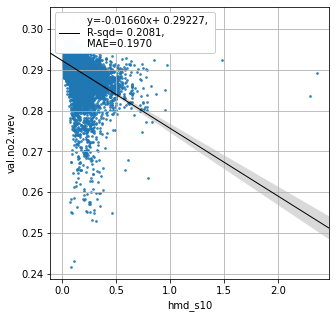

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sklearn.metrics
import numpy as np

x = (test.set_index(['tag','rec']).query('tag == "scs-bgx-538"')['hmd_s10'])
y = (test.set_index(['tag','rec']).query('tag == "scs-bgx-538"')['val.no2.wev'])

mae_dat = sklearn.metrics.mean_absolute_error(y.values, x.values)
slope, intercept, r_value, p_value, std_err = stats.linregress(x.values, y.values)

fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.regplot(x=x,y=y,
            scatter_kws={'s': 3},
                    line_kws={
                        'label': 'y={0: .5f}x+{1: .5f}, \nR-sqd={2: .4f}, \nMAE={3:.4f}'.format(slope, intercept, r_value**2, mae_dat),
                        'color': 'k',
                        'lw': 1
                    },
            truncate=False,
            ax=ax
           )
#ax.set_xlim(-1,1)
#ax.set_ylim(-0.002,0.002)
ax.grid()
ax.legend(framealpha=0.99, loc='upper left')


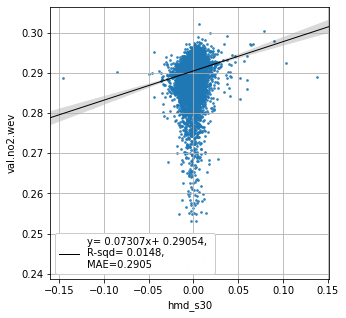

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sklearn.metrics
import numpy as np

x = (test_avg.set_index(['tag','rec']).query('tag == "scs-bgx-538"')['hmd_s30'])
y = (test_avg.set_index(['tag','rec']).query('tag == "scs-bgx-538"')['val.no2.wev'])

mae_dat = sklearn.metrics.mean_absolute_error(y.values, x.values)
slope, intercept, r_value, p_value, std_err = stats.linregress(x.values, y.values)

fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.regplot(x=x,y=y,
            scatter_kws={'s': 3},
                    line_kws={
                        'label': 'y={0: .5f}x+{1: .5f}, \nR-sqd={2: .4f}, \nMAE={3:.4f}'.format(slope, intercept, r_value**2, mae_dat),
                        'color': 'k',
                        'lw': 1
                    },
            truncate=False,
            ax=ax
           )
#ax.set_xlim(-1,1)
#ax.set_ylim(-0.002,0.002)
ax.grid()
ax.legend(framealpha=0.99, loc='lower left')


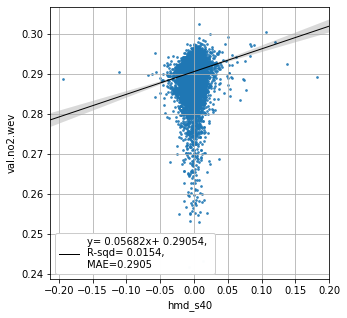

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sklearn.metrics
import numpy as np

x = (test_avg.set_index(['tag','rec']).query('tag == "scs-bgx-538"')['hmd_s40'])
y = (test_avg.set_index(['tag','rec']).query('tag == "scs-bgx-538"')['val.no2.wev'])

mae_dat = sklearn.metrics.mean_absolute_error(y.values, x.values)
slope, intercept, r_value, p_value, std_err = stats.linregress(x.values, y.values)

fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.regplot(x=x,y=y,
            scatter_kws={'s': 3},
                    line_kws={
                        'label': 'y={0: .5f}x+{1: .5f}, \nR-sqd={2: .4f}, \nMAE={3:.4f}'.format(slope, intercept, r_value**2, mae_dat),
                        'color': 'k',
                        'lw': 1
                    },
            truncate=False,
            ax=ax
           )
#ax.set_xlim(-1,1)
#ax.set_ylim(-0.002,0.002)
ax.grid()
ax.legend(framealpha=0.99, loc='lower left')


In [35]:
# Add names back on - oxaria1 gases
# -----------------------------

# Let list of tags
# ------------------
devices = oxaria1_gases_stable_15min.reset_index()['tag'].unique()

# Zip together with the tags as a dictionary * convert to df
# ------------------------------------------------------------
device_names = dict(zip(devices, ox1_location_names))
df_device_names = pd.DataFrame.from_dict(device_names,
                                         orient='index',
                                         columns=['name'])
df_device_names.index.name = 'tag'

# Merge with gases_4gas
# -----------------------
oxaria1_gases_stable_15min = oxaria1_gases_stable_15min.set_index(['tag','rec']).merge(df_device_names,
                                                              how='left',
                                                              left_index=True,
                                                              right_index=True)
print('Gases done.')

Gases done.


In [36]:
# Add names back on - oxaria1 pm
#-----------------------------

# Let list of tags 
#------------------
devices = oxaria1_pm_stable_15min.reset_index()['tag'].unique()

# Zip together with the tags as a dictionary * convert to df
#------------------------------------------------------------
device_names = dict(zip(devices, ox1_location_names))
df_device_names = pd.DataFrame.from_dict(device_names, \
                                         orient='index', \
                                         columns=['name'])
df_device_names.index.name = 'tag'

# Merge with gases_4gas
# -----------------------
oxaria1_pm_stable_15min = oxaria1_pm_stable_15min.set_index(['tag','rec']).merge(df_device_names,
                                                        how='left',
                                                        left_index=True,
                                                        right_index=True)
print('PM done.')

PM done.


In [37]:
# Add names back on - oxaria1 climate
# -----------------------------

# Let list of tags
# ------------------
devices = oxaria1_climate_stable_15min.reset_index()['tag'].unique()

# Zip together with the tags as a dictionary * convert to df
# ------------------------------------------------------------
device_names = dict(zip(devices, ox1_location_names))
df_device_names = pd.DataFrame.from_dict(device_names,
                                         orient='index',
                                         columns=['name'])
df_device_names.index.name = 'tag'

# Merge with gases_4gas
# -----------------------
oxaria1_climate_stable_15min = oxaria1_climate_stable_15min.set_index(['tag','rec']).merge(df_device_names,
                                                                  how='left',
                                                                  left_index=True,
                                                                  right_index=True)
print('Climate done.')

Climate done.


In [38]:
# Add names back on - oxaria1 status
# -----------------------------

# Let list of tags
# ------------------
devices = oxaria1_status_stable_15min.reset_index()['tag'].unique()

# Zip together with the tags as a dictionary * convert to df
# ------------------------------------------------------------
device_names = dict(zip(devices, ox1_location_names))
df_device_names = pd.DataFrame.from_dict(device_names,
                                         orient='index',
                                         columns=['name'])
df_device_names.index.name = 'tag'

# Merge with gases_4gas
# -----------------------
oxaria1_status_stable_15min = oxaria1_status_stable_15min.set_index(['tag','rec']).merge(df_device_names,
                                                                  how='left',
                                                                  left_index=True,
                                                                  right_index=True)
print('Status done.')

Status done.


In [45]:
# Calc 15-min averages - oxaria2
#-----------------------------------------------------------------------

print('Loading Oxaria2 gases, pm, climate, status & resampling...')

# File locations
the_folder = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/2oxaria/json/gap_filling/'

# Apply the function
oxaria2_gases_stable_15min = resample_15min(in_ftr=the_folder+'oxaria2_gases_stable_536_2feb21.ftr', \
                                            out_ftr=the_folder+'oxaria2_gases_stable_536_2feb21_15min.ftr')

oxaria2_pm_stable_15min = resample_15min(in_ftr=the_folder+'oxaria2_pm_stable_356_2feb21.ftr', \
                                         out_ftr=the_folder+'oxaria2_pm_stable_536_2feb21_15min.ftr')

oxaria2_climate_stable_15min = resample_15min(in_ftr=the_folder+'oxaria2_climate_stable_356_2feb21.ftr', \
                                            out_ftr=the_folder+'oxaria2_climate_stable_536_2feb21_15min.ftr')

oxaria2_status_stable_15min = resample_15min(in_ftr=the_folder+'oxaria2_status_stable_356_2feb21.ftr', \
                                         out_ftr=the_folder+'oxaria2_status_stable_356_2feb21.ftr')

print('\nJoining Oxaria2 names back on, resample drops non-numeric columns...')


Loading Oxaria2 gases, pm, climate, status & resampling...

Joining Oxaria2 names back on, resample drops non-numeric columns...


In [46]:
# Add names back on - oxaria2 pm
#-----------------------------------

# Let list of tags 
#------------------
devices = oxaria2_pm_stable_15min['tag'].unique()

# Zip together with the tags as a dictionary * convert to df
#------------------------------------------------------------
device_names = dict(zip(devices, ox2_location_names))
df_device_names = pd.DataFrame.from_dict(device_names, orient='index', columns=['name'])
df_device_names.index.name = 'tag'

# Merge with gases_4gas
#-----------------------
oxaria2_pm_stable_15min = oxaria2_pm_stable_15min.set_index(['tag','rec']).merge(df_device_names, how='left', left_index=True, right_index=True)

print('Gases done.')

Gases done.


In [47]:
# Add names back on - oxaria2 gases
#-----------------------------------

# Let list of tags 
#------------------
devices = oxaria2_gases_stable_15min['tag'].unique()

# Zip together with the tags as a dictionary * convert to df
#------------------------------------------------------------
device_names = dict(zip(devices, ox2_location_names))
df_device_names = pd.DataFrame.from_dict(device_names, orient='index', columns=['name'])
df_device_names.index.name = 'tag'

# Merge with gases_4gas
#-----------------------
oxaria2_gases_stable_15min = oxaria2_gases_stable_15min.set_index(['tag','rec']).merge(df_device_names, how='left', left_index=True, right_index=True)

print('PM done.')

PM done.


In [48]:
# Add names back on - oxaria2 climate
#-----------------------------------

# Let list of tags 
#------------------
devices = oxaria2_climate_stable_15min['tag'].unique()

# Zip together with the tags as a dictionary * convert to df
#------------------------------------------------------------
device_names = dict(zip(devices, ox2_location_names))
df_device_names = pd.DataFrame.from_dict(device_names, orient='index', columns=['name'])
df_device_names.index.name = 'tag'

# Merge with climate_4gas
#-----------------------
oxaria2_climate_stable_15min = oxaria2_climate_stable_15min.set_index(['tag','rec']).merge(df_device_names, how='left', left_index=True, right_index=True)

print('Climate done.')

Climate done.


In [49]:
# Add names back on - oxaria2 status
#-----------------------------------

# Let list of tags 
#------------------
devices = oxaria2_status_stable_15min['tag'].unique()

# Zip together with the tags as a dictionary * convert to df
#------------------------------------------------------------
device_names = dict(zip(devices, ox2_location_names))
df_device_names = pd.DataFrame.from_dict(device_names, orient='index', columns=['name'])
df_device_names.index.name = 'tag'

# Merge with status_4gas
#-----------------------
oxaria2_status_stable_15min = oxaria2_status_stable_15min.set_index(['tag','rec']).merge(df_device_names, how='left', left_index=True, right_index=True)

print('Status done.')

Status done.


In [50]:
# Concat oxaria 1, 2 & do some housekeeping & checks - gases
#------------------------------------------------------------
print('Combining Oxaria 1 & 2 gases...\n \n Saving to /home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_gases_536_stable.ftr')

oxaria_gases_stbl15 = pd.concat([oxaria1_gases_stable_15min, \
                                 oxaria2_gases_stable_15min])
oxaria_gases_stbl15.head()

oxaria_gases_stbl15 = oxaria_gases_stbl15[~oxaria_gases_stbl15.index.duplicated(keep='last')].sort_index()

oxaria_gases_stbl15.reset_index().to_feather('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_gases_536_stable15.ftr')
oxaria_gases_stbl15.info()

Combining Oxaria 1 & 2 gases...
 
 Saving to /home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_gases_536_stable.ftr
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 339525 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-03-01 00:00:00+0000', tz='UTC'))
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   val.no2.wev    339525 non-null  float32
 1   val.no2.cnc    339525 non-null  float32
 2   val.no2.aev    339525 non-null  float32
 3   val.no2.wec    339525 non-null  float32
 4   val.sht.hmd    339525 non-null  float32
 5   val.sht.tmp    339525 non-null  float32
 6   val.no2.cnc_1  335248 non-null  float32
 7   name           339525 non-null  object 
dtypes: float32(7), object(1)
memory usage: 14.8+ MB


In [51]:
# Concat oxaria 1, 2 & do some housekeeping & checks - pm
#---------------------------------------------------------
print('Combining Oxaria 1 & 2 pm...\n \n Saving to /home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_pm_536_stable.ftr')

oxaria_pm_stbl15 = pd.concat([oxaria1_pm_stable_15min, \
                              oxaria2_pm_stable_15min])
oxaria_pm_stbl15 = oxaria_pm_stbl15[~oxaria_pm_stbl15.index.duplicated(keep='last')].sort_index()
oxaria_pm_stbl15.reset_index().to_feather('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_pm_536_stable15.ftr')
oxaria_pm_stbl15.info()


Combining Oxaria 1 & 2 pm...
 
 Saving to /home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_pm_536_stable.ftr
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 341622 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-03-01 00:00:00+0000', tz='UTC'))
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   val.mtf1     341622 non-null  float32
 1   val.pm1      341622 non-null  float32
 2   val.mtf5     341622 non-null  float32
 3   val.pm2p5    341622 non-null  float32
 4   val.mtf3     341622 non-null  float32
 5   val.pm10     341622 non-null  float32
 6   val.mtf7     341622 non-null  float32
 7   val.per      341622 non-null  float32
 8   val.sfr      341622 non-null  float32
 9   val.sht.hmd  341622 non-null  float32
 10  val.sht.tmp  341622 non-null  float32
 11  val.pm10_1   263122 non-null  float32
 12  val.pm2p5_1  263122 n

In [52]:
# Concat oxaria 1, 2 & do some housekeeping & checks - climate
#--------------------------------------------------------------
print('Combining Oxaria 1 & 2 climate...\n \n Saving to /home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_climate_536_stable.ftr')

oxaria_climate_stbl15 = pd.concat([oxaria1_climate_stable_15min, \
                              oxaria2_climate_stable_15min]).drop(labels='index', axis=1)
oxaria_climate_stbl15 = oxaria_climate_stbl15[~oxaria_climate_stbl15.index.duplicated(keep='last')].sort_index()
oxaria_climate_stbl15.reset_index().to_feather('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_climate_536_stable15.ftr')
oxaria_climate_stbl15.info()


Combining Oxaria 1 & 2 climate...
 
 Saving to /home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_climate_536_stable.ftr
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 341623 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-03-01 00:00:00+0000', tz='UTC'))
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   val.hmd  341623 non-null  float32
 1   val.tmp  341623 non-null  float32
 2   name     341623 non-null  object 
dtypes: float32(2), object(1)
memory usage: 8.4+ MB


In [53]:
# Concat oxaria 1, 2 & do some housekeeping & checks - status
#-------------------------------------------------------------
print('Combining Oxaria 1 & 2 status...\n \n Saving to /home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_status_536_stable.ftr')

oxaria_status_stbl15 = pd.concat([oxaria1_status_stable_15min, \
                              oxaria2_status_stable_15min])
oxaria_status_stbl15 = oxaria_status_stbl15[~oxaria_status_stbl15.index.duplicated(keep='last')].sort_index()
oxaria_status_stbl15.reset_index().to_feather('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_status_536_stable15.ftr')
oxaria_status_stbl15.info()

print('All done! \U0001F600')

Combining Oxaria 1 & 2 status...
 
 Saving to /home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/oxaria_status_536_stable.ftr
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 341622 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-03-01 00:15:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   val.up.load.av15   341622 non-null  float32
 1   val.up.load.av1    341622 non-null  float32
 2   val.up.load.av5    341622 non-null  float32
 3   val.up.users       341622 non-null  float32
 4   val.psu.prot-batt  341064 non-null  float32
 5   val.psu.rst        341064 non-null  float32
 6   val.psu.chg        341064 non-null  float32
 7   val.psu.pwr-in     341064 non-null  float32
 8   val.psu.host-3v3   341064 non-null  float32
 9   val.tmp.brd        341622 non-null  float32
 10  name               341622 n